Training data: (2906, 8)
Test data: (132, 15)
Loading tokenizer: SZTAKI-HLT/hubert-base-cc
✓ Tokenizer loaded successfully!
  Vocabulary size: 32001
  Model max length: 1000000000000000019884624838656

TOKENIZING TEXTS TO ANALYZE TOKEN LENGTHS

Token-level statistics:
Train - Mean: 82.6, Median: 62.0
Train - Min: 10, Max: 1743
Test  - Mean: 65.9, Median: 57.5
Test  - Min: 14, Max: 186

Training token length percentiles:
   50th percentile: 62 tokens
   75th percentile: 99 tokens
   90th percentile: 153 tokens
   95th percentile: 200 tokens
   99th percentile: 390 tokens
  100th percentile: 1743 tokens


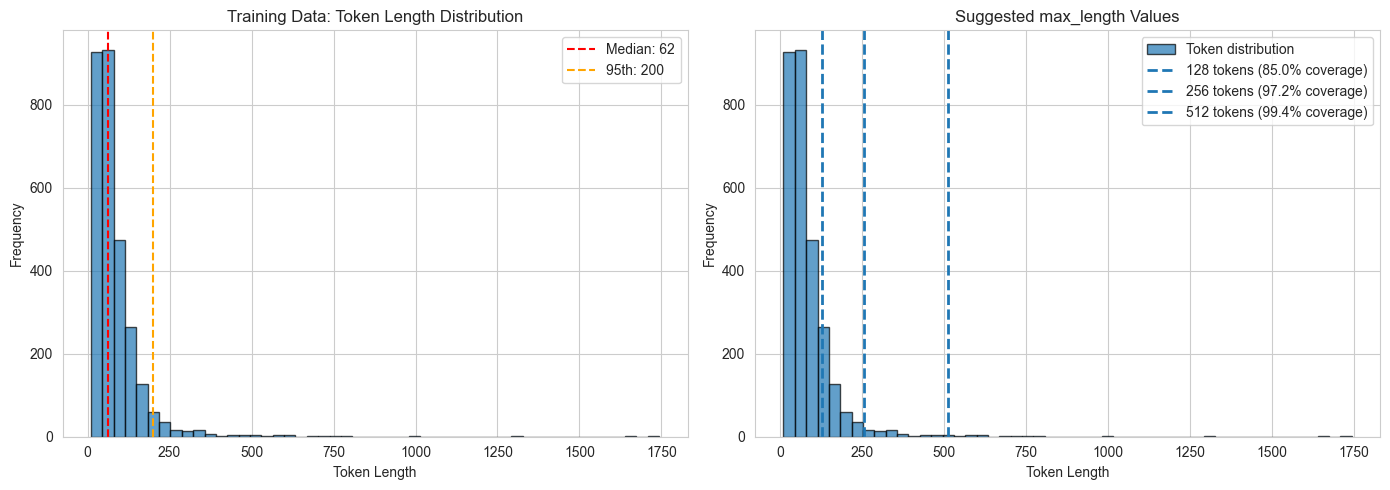


COVERAGE ANALYSIS FOR DIFFERENT max_length VALUES

max_length = 128:
  Train coverage: 85.00% (436 texts truncated)
  Test coverage:  92.42% (10 texts truncated)

max_length = 256:
  Train coverage: 97.18% (82 texts truncated)
  Test coverage:  100.00% (0 texts truncated)

max_length = 512:
  Train coverage: 99.38% (18 texts truncated)
  Test coverage:  100.00% (0 texts truncated)
TOKENIZING DATASETS

Tokenization parameters:
  max_length: 256
  padding: 'max_length'
  truncation: True
  return_attention_mask: True

Tokenizing training data...
✓ Training data tokenized: 2906 samples
Tokenizing test data...
✓ Test data tokenized: 132 samples

VERIFICATION

Training set:
  input_ids shape: 2906 × 256
  attention_mask shape: 2906 × 256
  labels: 2906 samples

Test set:
  input_ids shape: 132 × 256
  attention_mask shape: 132 × 256
  labels: 132 samples

EXAMPLE: First Training Sample

Original text (first 100 chars):
  1. Szerződés tárgya
A Vállalkozó az alvállalkozói szerződésben megjel

In [ ]:
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import warnings
import yaml
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# %%
# Load training and test data
train_path = Path('../_data/final/train.csv')
test_path = Path('../_data/final/test.csv')

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")

# Load Hungarian BERT tokenizer
model_name = 'SZTAKI-HLT/hubert-base-cc'
print(f"Loading tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"✓ Tokenizer loaded successfully!")
print(f"  Vocabulary size: {tokenizer.vocab_size}")
print(f"  Model max length: {tokenizer.model_max_length}")

# Tokenize all texts to see token distribution
print("\n" + "="*60)
print("TOKENIZING TEXTS TO ANALYZE TOKEN LENGTHS")
print("="*60)

train_token_lengths = []
for text in df_train['text']:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    train_token_lengths.append(len(tokens))

test_token_lengths = []
for text in df_test['text']:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    test_token_lengths.append(len(tokens))

train_token_lengths = np.array(train_token_lengths)
test_token_lengths = np.array(test_token_lengths)

print("\nToken-level statistics:")
print(f"Train - Mean: {train_token_lengths.mean():.1f}, Median: {np.median(train_token_lengths):.1f}")
print(f"Train - Min: {train_token_lengths.min()}, Max: {train_token_lengths.max()}")
print(f"Test  - Mean: {test_token_lengths.mean():.1f}, Median: {np.median(test_token_lengths):.1f}")
print(f"Test  - Min: {test_token_lengths.min()}, Max: {test_token_lengths.max()}")

# Token length percentiles
print("\nTraining token length percentiles:")
for p in [50, 75, 90, 95, 99, 100]:
    val = np.percentile(train_token_lengths, p)
    print(f"  {p:3d}th percentile: {val:.0f} tokens")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_token_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.median(train_token_lengths), color='red', linestyle='--', label=f"Median: {np.median(train_token_lengths):.0f}")
axes[0].axvline(np.percentile(train_token_lengths, 95), color='orange', linestyle='--', label=f"95th: {np.percentile(train_token_lengths, 95):.0f}")
axes[0].set_xlabel('Token Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Data: Token Length Distribution')
axes[0].legend()

# Suggest max_length values
suggested_lengths = [128, 256, 512]
axes[1].hist(train_token_lengths, bins=50, edgecolor='black', alpha=0.7, label='Token distribution')
for length in suggested_lengths:
    coverage = (train_token_lengths <= length).sum() / len(train_token_lengths) * 100
    axes[1].axvline(length, linestyle='--', linewidth=2, label=f"{length} tokens ({coverage:.1f}% coverage)")
axes[1].set_xlabel('Token Length')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Suggested max_length Values')
axes[1].legend()

plt.tight_layout()
plt.show()

# Coverage analysis
print("\n" + "="*60)
print("COVERAGE ANALYSIS FOR DIFFERENT max_length VALUES")
print("="*60)
for max_len in [128, 256, 512]:
    train_coverage = (train_token_lengths <= max_len).sum() / len(train_token_lengths) * 100
    test_coverage = (test_token_lengths <= max_len).sum() / len(test_token_lengths) * 100
    train_truncated = (train_token_lengths > max_len).sum()
    test_truncated = (test_token_lengths > max_len).sum()
    print(f"\nmax_length = {max_len}:")
    print(f"  Train coverage: {train_coverage:.2f}% ({train_truncated} texts truncated)")
    print(f"  Test coverage:  {test_coverage:.2f}% ({test_truncated} texts truncated)")


print("="*60)
print("TOKENIZING DATASETS")
print("="*60)

# Set max_length based on our analysis
MAX_LENGTH = 256

print(f"\nTokenization parameters:")
print(f"  max_length: {MAX_LENGTH}")
print(f"  padding: 'max_length'")
print(f"  truncation: True")
print(f"  return_attention_mask: True")

def tokenize_texts(texts, labels, tokenizer, max_length):
    """
    Tokenize texts and prepare them for BERT model.

    Returns:
        Dictionary with input_ids, attention_mask, and labels
    """
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors=None  # Return lists, not tensors (for flexibility)
    )

    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels.tolist()
    }

# Tokenize training data
print("\nTokenizing training data...")
train_encodings = tokenize_texts(
    df_train['text'].values,
    df_train['label_numeric'].values,
    tokenizer,
    MAX_LENGTH
)
print(f"✓ Training data tokenized: {len(train_encodings['input_ids'])} samples")

# Tokenize test data
print("Tokenizing test data...")
test_encodings = tokenize_texts(
    df_test['text'].values,
    df_test['label_numeric'].values,
    tokenizer,
    MAX_LENGTH
)
print(f"✓ Test data tokenized: {len(test_encodings['input_ids'])} samples")

# Verify shapes
print("\n" + "="*60)
print("VERIFICATION")
print("="*60)
print(f"\nTraining set:")
print(f"  input_ids shape: {len(train_encodings['input_ids'])} × {len(train_encodings['input_ids'][0])}")
print(f"  attention_mask shape: {len(train_encodings['attention_mask'])} × {len(train_encodings['attention_mask'][0])}")
print(f"  labels: {len(train_encodings['labels'])} samples")

print(f"\nTest set:")
print(f"  input_ids shape: {len(test_encodings['input_ids'])} × {len(test_encodings['input_ids'][0])}")
print(f"  attention_mask shape: {len(test_encodings['attention_mask'])} × {len(test_encodings['attention_mask'][0])}")
print(f"  labels: {len(test_encodings['labels'])} samples")

# Show example of first sample
print("\n" + "="*60)
print("EXAMPLE: First Training Sample")
print("="*60)
print(f"\nOriginal text (first 100 chars):")
print(f"  {df_train.iloc[0]['text'][:100]}...")
print(f"\nLabel: {df_train.iloc[0]['label_numeric']} ({df_train.iloc[0]['label_text']})")
print(f"\nTokenized (first 20 tokens):")
print(f"  input_ids: {train_encodings['input_ids'][0][:20]}")
print(f"  attention_mask: {train_encodings['attention_mask'][0][:20]}")
print(f"\nDecoded tokens (first 10):")
tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][0][:10])
print(f"  {tokens}")

# Compute class weights
unique_labels = np.unique(df_train['label_numeric'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=df_train['label_numeric']
)
class_weights_dict = dict(zip(unique_labels, class_weights))

print("\nComputed class weights:")
for label, weight in class_weights_dict.items():
    print(f"  Class {label}: {weight:.4f}")

print("="*60)
print("CREATING TRAIN/VALIDATION SPLIT")
print("="*60)

# Create validation split (80/20 split, stratified by label)
train_indices, val_indices = train_test_split(
    range(len(train_encodings['input_ids'])),
    test_size=0.2,
    random_state=42,
    stratify=train_encodings['labels']
)

print(f"\nSplit sizes:")
print(f"  Training:   {len(train_indices)} samples ({len(train_indices)/len(train_encodings['input_ids'])*100:.1f}%)")
print(f"  Validation: {len(val_indices)} samples ({len(val_indices)/len(train_encodings['input_ids'])*100:.1f}%)")
print(f"  Test:       {len(test_encodings['input_ids'])} samples")

# Create separate datasets
train_dataset = {
    'input_ids': [train_encodings['input_ids'][i] for i in train_indices],
    'attention_mask': [train_encodings['attention_mask'][i] for i in train_indices],
    'labels': [train_encodings['labels'][i] for i in train_indices]
}

val_dataset = {
    'input_ids': [train_encodings['input_ids'][i] for i in val_indices],
    'attention_mask': [train_encodings['attention_mask'][i] for i in val_indices],
    'labels': [train_encodings['labels'][i] for i in val_indices]
}

# Verify label distribution in splits
print("\nLabel distribution after split:")
print("\nTraining:")
train_labels_dist = pd.Series(train_dataset['labels']).value_counts().sort_index()
for label, count in train_labels_dist.items():
    pct = (count / len(train_dataset['labels'])) * 100
    print(f"  Class {label}: {count:4d} samples ({pct:5.2f}%)")

print("\nValidation:")
val_labels_dist = pd.Series(val_dataset['labels']).value_counts().sort_index()
for label, count in val_labels_dist.items():
    pct = (count / len(val_dataset['labels'])) * 100
    print(f"  Class {label}: {count:4d} samples ({pct:5.2f}%)")

# Save preprocessed data
print("\n" + "="*60)
print("SAVING PREPROCESSED DATA")
print("="*60)

output_dir = Path('../_data/preprocessed')
output_dir.mkdir(parents=True, exist_ok=True)

# Save datasets
with open(output_dir / 'train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)
print(f"✓ Saved: train_dataset.pkl ({len(train_dataset['labels'])} samples)")

with open(output_dir / 'val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)
print(f"✓ Saved: val_dataset.pkl ({len(val_dataset['labels'])} samples)")

with open(output_dir / 'test_dataset.pkl', 'wb') as f:
    pickle.dump(test_encodings, f)
print(f"✓ Saved: test_dataset.pkl ({len(test_encodings['labels'])} samples)")

# Save class weights
with open(output_dir / 'class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights_dict, f)
print(f"✓ Saved: class_weights.pkl")

# Save preprocessing config
config = {
    'model_name': model_name,
    'max_length': MAX_LENGTH,
    'train_size': len(train_dataset['labels']),
    'val_size': len(val_dataset['labels']),
    'test_size': len(test_encodings['labels']),
    'num_classes': 5
}

with open(output_dir / 'config.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False, allow_unicode=True)
print(f"✓ Saved: config.yaml")

print(f"\nAll preprocessed data saved to: {output_dir.absolute()}")